# Recognising handwritten digits (MNIST)
_The "Hello world" of neural networks_

In [7]:
# Typical Imports: torch, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# This is a function just to give us pretty outputs of an image and what our model believes a digit to be
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [10]:
# First of all, import the data we will be working with

# We define a transform to normalize the data just so what we can apply it after we import the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download and load the training data (Set download to False if you've run this before)
trainset    = datasets.MNIST('MNIST_data/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

# Same as above but for the testing data
testset    = datasets.MNIST('MNIST_data/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



102.8%


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



112.7%

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw




C:\Users\tom\anaconda3\envs\poggers\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
# This is a useful way of moving/iterating through our data
dataiter = iter(trainloader)
# .next() will return the next batch of data, great!
images, labels = dataiter.next()
# Here's the shape of a batch of images, 16 images with 1 colour, 28 pixels high by 28 pixels wide
images.shape

torch.Size([16, 1, 28, 28])

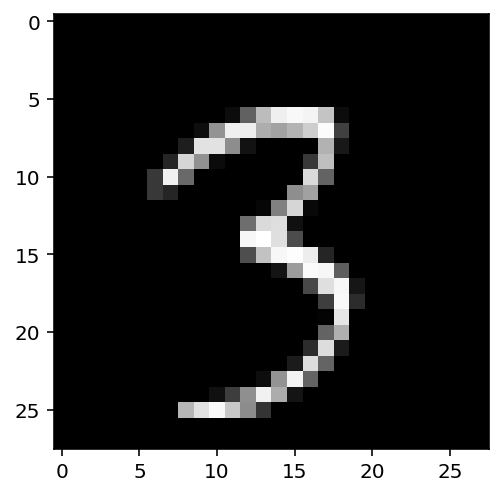

In [29]:
import random
# Here's what an image looks like to us
plt.imshow(images[random.randint(0,15)].numpy().squeeze(), cmap='Greys_r');

In [14]:
# Now to construct a network
# The typical practice when using pytorch is to rewrite an __init__ and forward pass
# for the default network class but with whatever you need for your actual network.


# For example, we are going to send 28x28 pixels (784) into our network,
# then pass them to smaller and smaller layers
# Typically each layer will be 2^n in size as computers just love those numbers.
class MNIST_Network(nn.Module):

    # Defining the layers
    def __init__(self):
        super().__init__()
        # fc for "Fully Connected" layer
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 10)

    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        # relu is typically imported like this:
        # import torch.nn.functional as F
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # Softmax just makes all our outputs total to "1", useful for visualising results like "90% sure this is an 8"
        x = F.softmax(x, dim=1)
        return x

model = MNIST_Network()
model

MNIST_Network(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)

In [72]:
# There are other ways to define a network, some methods may be easier to adjust
# You could define hyperparameters separately
input_size = 784
hidden_sizes = [32, 16]
output_size = 10

# Then use these with the nn.Sequential() function to make a feed forward model
# https://pytorch.org/docs/master/generated/torch.nn.Sequential.html#torch.nn.Sequential
sequential_model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.Softmax(dim=1)
)

sequential_model

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

In [31]:
# An 'OrderedDict' can be used if you want to name each layer
labelled_sequential_model = nn.Sequential(
    OrderedDict([
        ('First Layer', nn.Linear(input_size, hidden_sizes[0])),
        ('First ReLU', nn.ReLU()),
        ('Second Layer', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
        ('Second ReLU', nn.ReLU()),
        ('Final Layer', nn.Linear(hidden_sizes[1], output_size)),
        ('Outputs', nn.Softmax(dim=1))
    ])
)

labelled_sequential_model

Sequential(
  (First Layer): Linear(in_features=784, out_features=32, bias=True)
  (First ReLU): ReLU()
  (Second Layer): Linear(in_features=32, out_features=16, bias=True)
  (Second ReLU): ReLU()
  (Final Layer): Linear(in_features=16, out_features=10, bias=True)
  (Outputs): Softmax(dim=1)
)

In [43]:
# Weights and biases are already done for you, initialised randomly.
# You CAN tinker with them if you need to...

#print(model.fc1.weight) # WEIGHT, Just the one
#print(model.fc1.bias)

# These are actually autograd variables, in order to directly alter them, we would use weight.data:
#model.fc1.weight.data
model.fc1.weight.data.fill_(0)  # Set them all to 0
model.fc1.bias.data.normal_(std=0.1) # Fill the biases with values from a normal distribution

tensor([ 0.0038,  0.0106, -0.1224, -0.2014,  0.1138,  0.1214, -0.0781,  0.2942,
         0.1575, -0.1409,  0.0246, -0.0683, -0.0085, -0.0217, -0.0062, -0.0662,
         0.0470,  0.0251, -0.0526,  0.1228, -0.0065,  0.0479,  0.1967, -0.0940,
        -0.0256, -0.1054, -0.0240, -0.1151, -0.0055, -0.0336,  0.0997,  0.0151])

In [66]:
# So, now that we have a network/model, let's try it out!
# From earlier, we can use the loaders to iterate over the data
dataiter = iter(trainloader)
images, labels = dataiter.next()  # Gives us the next item

print(images.size())
# We need to turn this from a grid of pixel values to just a 1D array, just numbers one after another
# Our iterater actually gives us a batch of images, so the syntax here is (batch_size, colour_channels, pixels)
images = images.reshape(images.shape[0], 1, 784)
images.size()

torch.Size([16, 1, 28, 28])


torch.Size([16, 1, 784])

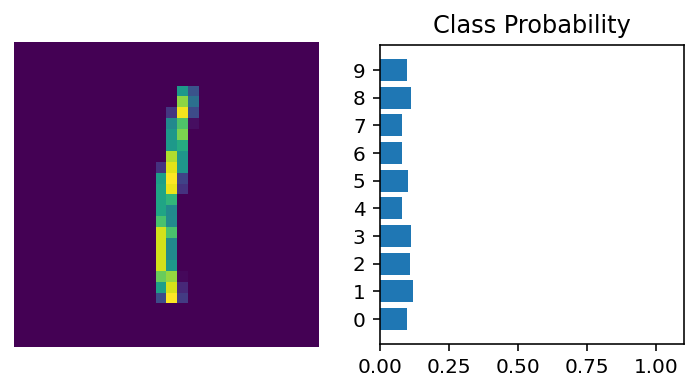

In [67]:
# Now we can give this to the network
image_index = 0
model_guess = model(images[image_index])

# Annnnd use the helper function from earlier to take a look
actual_image = images[image_index]
view_classify(actual_image, model_guess)
# Excellent! Our untrained model has no idea what that is, time to train it!

In [79]:
model_to_train = nn.Sequential(
    OrderedDict([
        ('First_Layer', nn.Linear(input_size, hidden_sizes[0])),
        ('First_ReLU', nn.ReLU()),
        ('Second_Layer', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
        ('Second_ReLU', nn.ReLU()),
         # Logits are the raw output of the network, using softmax while training could lead to some BIG accuracy losses
        ('Final_Layer', nn.Linear(hidden_sizes[1], output_size)),
        # No softmax this time
        #('Softmax', nn.Softmax(dim=1)
    ])
)

# We need a loss function in order to score the model, this one is used for classification of multiple classes
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
loss_function = nn.CrossEntropyLoss()
# And some way to optimise the loss
# Stochastic Gradient Descent is an okay choice for this
optimiser = optim.SGD(model_to_train.parameters(), lr=0.1)

"""
A Reminder on how a training loop typically works:
Give a model some data
Calculate how well it did with the loss function
Backpropagate to calculate the gradients (how to adjust the weights)
Step with the optimiser to apply those changes

Let's do this once
"""
# Reset the optimiser
optimiser.zero_grad() # Some networks like Recurrent NNs may not want the gradients zeroed, but we do
images, labels = next(iter(trainloader))
images = images.reshape(16, 784)

# Pass some data forward through the network
model_guess = model_to_train(images)
# Calculate a score using the loss function
loss = loss_function(model_guess, labels)
# Backpropagate
loss.backward()
# Apply the calculated adjustments
optimiser.step()

# Annnnd that's one training step! Only difference between this and the actual training is doing it much more!

In [90]:
# Above training but with print outputs
print("="*50)
optimiser.zero_grad()
print("Gradients Reset!")
print(f"Initial Weights: \n{model_to_train.First_Layer.weight.data}")
print("Feeding forward...")
model_guess = model_to_train(images)
print("Calculating loss...")
loss = loss_function(model_guess, labels)
print(f"Current loss: {loss:.5f}")
print("Backpropogating...")
loss.backward()
print(f"Gradients: \n{model_to_train.First_Layer.weight.grad}")
print("Altering weights...")
optimiser.step()
print(f"Updated weights: \n{model_to_train.First_Layer.weight.data} ")
print("="*50)

Gradients Reset!
Initial Weights: 
tensor([[-0.0074,  0.0091, -0.0330,  ..., -0.0338,  0.0142, -0.0327],
        [-0.0168,  0.0221,  0.0238,  ...,  0.0154,  0.0018,  0.0254],
        [ 0.0132,  0.0216,  0.0119,  ..., -0.0008, -0.0021,  0.0191],
        ...,
        [ 0.0062, -0.0225, -0.0196,  ...,  0.0259,  0.0275,  0.0284],
        [ 0.0085,  0.0031, -0.0170,  ...,  0.0196, -0.0332,  0.0066],
        [-0.0216, -0.0053,  0.0154,  ...,  0.0176, -0.0137,  0.0304]])
Feeding forward...
Calculating loss...
Current loss: 2.10095
Backpropogating...
Gradients: 
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0082,  0.0082,  0.0082,  ...,  0.0082,  0.0082,  0.0082],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        ...,
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
Alter

In [140]:
# Now for the big training loop, I'll include everything we need

# Define a transform that we apply as the data is loaded
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
# Download and load the training data (Set download to False if you've run this before)
trainset    = datasets.MNIST('MNIST_data/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
# Same as above but for the testing data
testset    = datasets.MNIST('MNIST_data/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

# The model
input_size = 784
hidden_sizes =  [128, 64]
output_size = 10
model = nn.Sequential(
    OrderedDict([
        ('First_Layer', nn.Linear(input_size, hidden_sizes[0])),
        ('First_ReLU', nn.ReLU()),
        ('Second_Layer', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
        ('Second_ReLU', nn.ReLU()),
        ('Final_Layer', nn.Linear(hidden_sizes[1], output_size)),
        ('Final_ReLU', nn.ReLU())
    ])
)

# Model parameters
optimiser = optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

training_epochs = 3
print_every = 500 # Just so we have a manageable amount of text displayed

for epoch in range(training_epochs):
    running_loss = 0
    print(f"Epoch {epoch+1} / {training_epochs}")

    for cycle, (images, labels) in enumerate(iter(trainloader)):
        # Flatten the images for our network
        images = images.reshape(16, 784)
        # Zero out the gradients
        optimiser.zero_grad()
        # Make a guess by passing an image forward through the network
        model_guess = model.forward(images)
        # Calculate how good/bad that guess is
        loss_value = loss_function(model_guess, labels)
        # Backpropogate to see how we need to adjust the weights
        loss_value.backward()
        # Adjust the weights
        optimiser.step()

        # Keep track of the loss for our human eyes to see
        running_loss += loss_value.item()

        if cycle % print_every == 0:
            print(f"Training cycle: {cycle}\t Avg. Loss: {running_loss/print_every:.4f}")
            running_loss = 0

print("="*50)
print("DONE")

Epoch 1 / 3
Training cycle: 0	 Avg. Loss: 0.0046
Training cycle: 500	 Avg. Loss: 1.6074
Training cycle: 1000	 Avg. Loss: 0.5905
Training cycle: 1500	 Avg. Loss: 0.4368
Training cycle: 2000	 Avg. Loss: 0.4019
Training cycle: 2500	 Avg. Loss: 0.3508
Training cycle: 3000	 Avg. Loss: 0.3465
Training cycle: 3500	 Avg. Loss: 0.3156
Epoch 2 / 3
Training cycle: 0	 Avg. Loss: 0.0010
Training cycle: 500	 Avg. Loss: 0.2944
Training cycle: 1000	 Avg. Loss: 0.2713
Training cycle: 1500	 Avg. Loss: 0.2725
Training cycle: 2000	 Avg. Loss: 0.2620
Training cycle: 2500	 Avg. Loss: 0.2424
Training cycle: 3000	 Avg. Loss: 0.2526
Training cycle: 3500	 Avg. Loss: 0.2306
Epoch 3 / 3
Training cycle: 0	 Avg. Loss: 0.0003
Training cycle: 500	 Avg. Loss: 0.2071
Training cycle: 1000	 Avg. Loss: 0.1936
Training cycle: 1500	 Avg. Loss: 0.1868
Training cycle: 2000	 Avg. Loss: 0.1897
Training cycle: 2500	 Avg. Loss: 0.2028
Training cycle: 3000	 Avg. Loss: 0.1963
Training cycle: 3500	 Avg. Loss: 0.1616
DONE


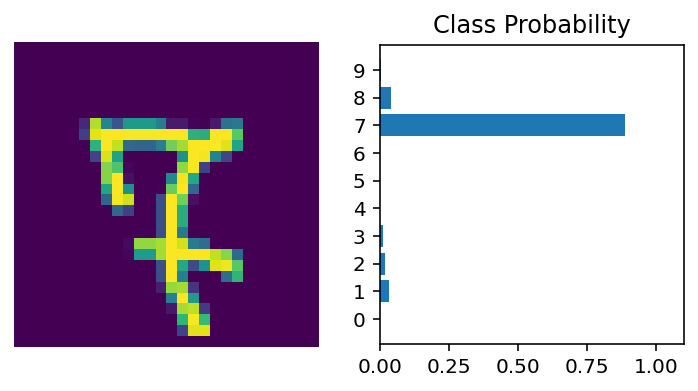

In [145]:
# Okay, we have now trained a model on all the data, let's see how it does now...
images, labels = next(iter(testloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Softmax on the raw network output to get a "I'm 90% it's this number" output
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)